# Setup

In [4]:
%cd /scratch/bruingjde/SNAM2021-code/
import importlib
import os

import joblib
import pandas as pd

import tlp

dataset_id = '01'
url = 'http://konect.cc/files/download.tsv.dblp_coauthor.tar.bz2'
adjusted_intervals = dict(t_min=pd.Timestamp('1996-01-01'), 
                          t_split=pd.Timestamp('2005-01-01'),
                          t_max=pd.Timestamp('2007-01-01'))
path = f'data/{dataset_id}'

/scratch/bruingjde/SNAM2021-code


# Download and extract data

In [10]:
joblib.load('data/01/edgelist_mature.pkl').shape[0] / (joblib.load('data/01/edgelist_mature.pkl').shape[0] + joblib.load('data/01/edgelist_probe.pkl').shape[0])

0.647486298993533

3937798

# Splitting

In [3]:
%%time
filepath_edgelist = f'{dataset_id}/edgelist.pkl'
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_probe = f'{dataset_id}/edgelist_probe.pkl'

if not os.path.isfile(filepath_mature) or not os.path.isfile(filepath_probe):
  edgelist_mature, edgelist_probe = tlp.split_in_intervals(
    edgelist=joblib.load(filepath_edgelist), **adjusted_intervals)
  joblib.dump(edgelist_mature, filepath_mature)
  joblib.dump(edgelist_probe, filepath_probe)

CPU times: user 191 µs, sys: 0 ns, total: 191 µs
Wall time: 174 µs


# Instances

In [4]:
%%time
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_instances = f'{dataset_id}/instances.pkl'

if not os.path.isfile(filepath_instances):
  instances = tlp.get_instances(edgelist_mature=joblib.load(filepath_mature),
    verbose=True)
  joblib.dump(instances, filepath_instances)

CPU times: user 6 µs, sys: 22 µs, total: 28 µs
Wall time: 24.6 µs


# Targets

In [5]:
%%time
filepath_instances = f'{dataset_id}/instances.pkl'
filepath_probe = f'{dataset_id}/edgelist_probe.pkl'
filepath_targets = f'{dataset_id}/targets.pkl'

if not os.path.isfile(filepath_targets):
  targets = tlp.get_targets(
    instances=joblib.load(filepath_instances),
    edgelist_probe=joblib.load(filepath_probe),
    verbose=True)
  joblib.dump(targets, filepath_targets)

CPU times: user 20 µs, sys: 70 µs, total: 90 µs
Wall time: 81.5 µs


# Sampling

In [6]:
%%time
filepath_instances = f'{dataset_id}/instances.pkl'
filepath_targets = f'{dataset_id}/edgelist_targets.pkl'
filepath_instances_sampled = f'{dataset_id}/instances_sampled.pkl'
filepath_targets_sampled = f'{dataset_id}/targets_sampled.pkl'

if not (os.path.isfile(filepath_instances_sampled) and 
        os.path.isfile(filepath_targets_sampled)):
  instances_sampled, targets_sampled = tlp.balanced_sample(instances, targets)
  joblib.dump(instances_sampled, f'{dataset_id}/instances_sampled.pkl')
  joblib.dump(targets_sampled, f'{dataset_id}/targets_sampled.pkl')

CPU times: user 29 µs, sys: 103 µs, total: 132 µs
Wall time: 128 µs


# Features

## AA (time agnostic)

In [22]:
%%time
filepath = f'{dataset_id}/features'
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_instances_sampled = f'{dataset_id}/instances_sampled.pkl'

adamic_adar_time_agnostic = tlp.features.adamic_adar_time_agnostic(
  edgelist=joblib.load(filepath_mature),
  instances=joblib.load(filepath_instances_sampled),
  path=filepath)

CPU times: user 26.9 ms, sys: 40.9 ms, total: 67.9 ms
Wall time: 67.3 ms


## AA (time aware)

In [25]:
%%time
filepath = f'{dataset_id}/features'
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_instances_sampled = f'{dataset_id}/instances_sampled.pkl'

adamic_adar_time_aware = tlp.features.adamic_adar_time_aware(
  edgelist=joblib.load(filepath_mature),
  instances=joblib.load(filepath_instances_sampled),
  path=filepath,
  verbose=True)

CPU times: user 28.1 ms, sys: 42 ms, total: 70.1 ms
Wall time: 69.4 ms


# Analysis

## Figure: Edge distribution with maturing and probing intervals indicated

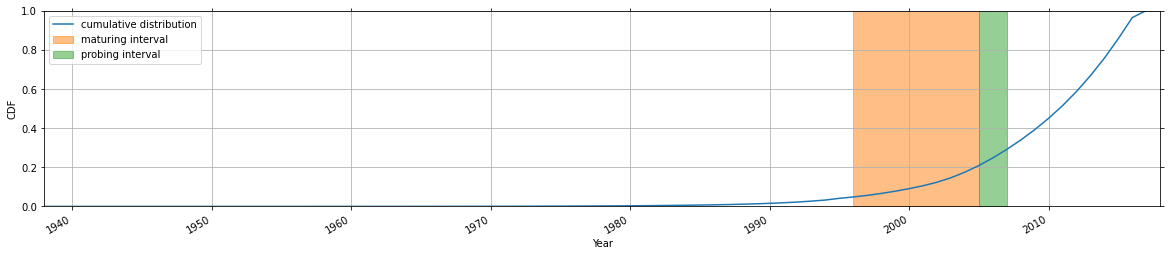

In [26]:
tlp.analysis.plot_datetime(
  joblib.load(f'{dataset_id}/edgelist.pkl')['datetime'], **adjusted_intervals)

## Metric: Class imbalance

In [27]:
tlp.analysis.class_imbalance(targets=joblib.load(f'{dataset_id}/targets.pkl'))

,absolute,relative
False,10884158,0.996291
True,40525,0.003709


## Figure: Datetime strategies

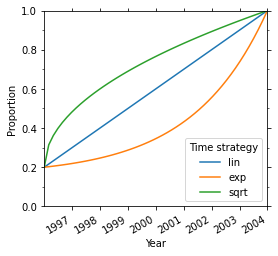

In [28]:
edgelist = joblib.load(f'{dataset_id}/edgelist_mature.pkl')
t = tlp.analysis.plot_datetime_strategies(edgelist['datetime'])

## Figure: Datetime distribution

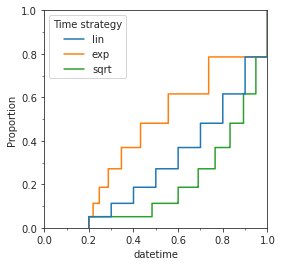

In [29]:
edgelist = joblib.load(f'{dataset_id}/edgelist_mature.pkl')
tlp.analysis.plot_datetime_distribution(edgelist['datetime'])

## Figure: Scores

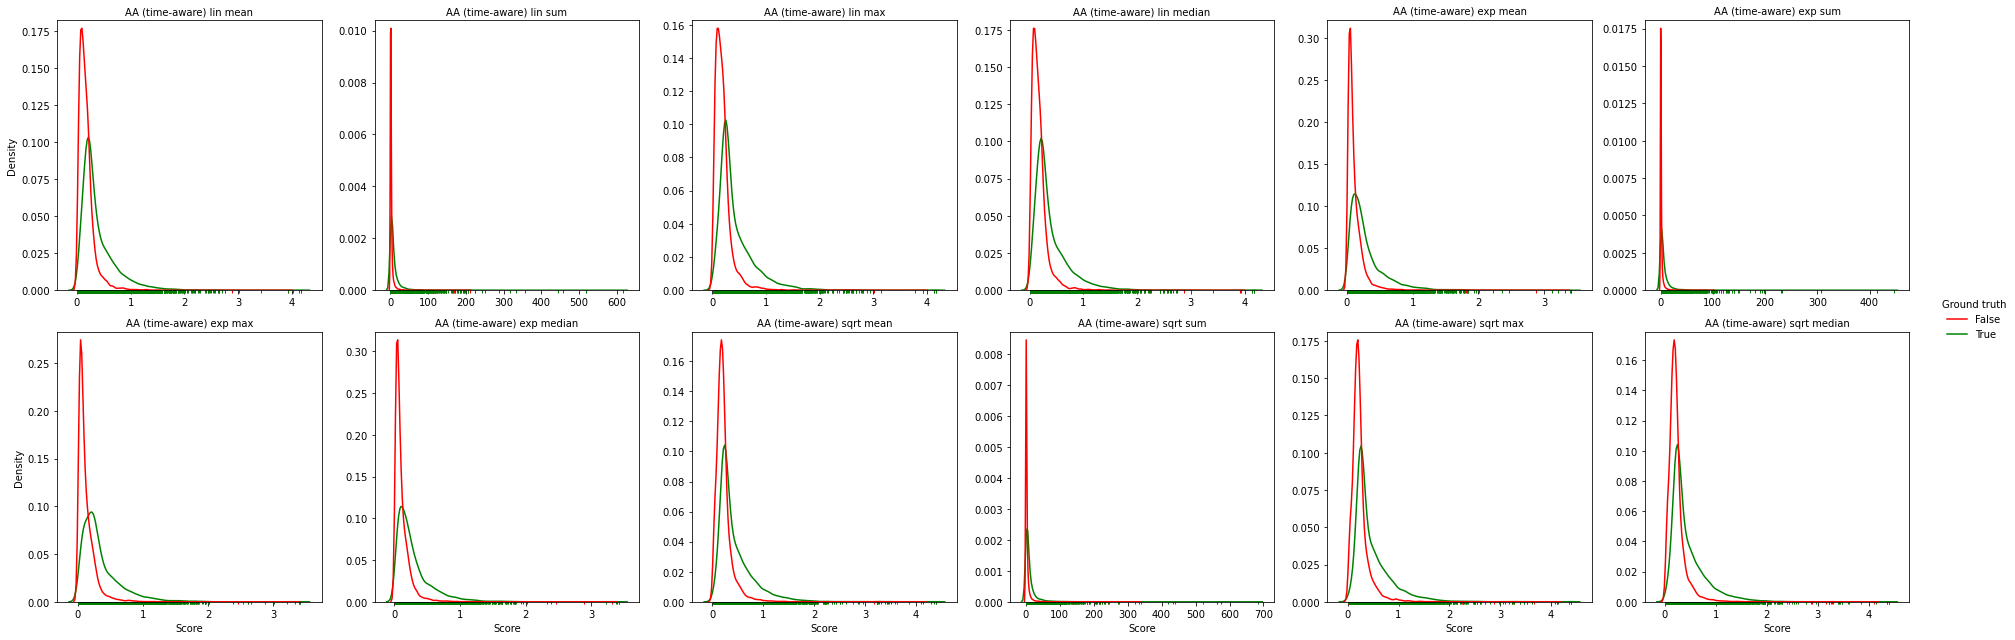

In [34]:
feature_dict = dict()
for file in os.scandir(f'{dataset_id}/features'):
  if file.is_file():
    feature_dict.update(joblib.load(file.path))
targets=joblib.load('01/targets_sampled.pkl')

tlp.analysis.plot_score(feature_dict, targets)

## Figure: ROC

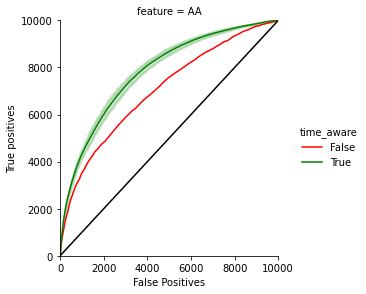

In [35]:
feature_dict = dict()
for file in os.scandir(f'{dataset_id}/features'):
  if file.is_file():
    feature_dict.update(joblib.load(file.path))
targets=joblib.load('01/targets_sampled.pkl')

tlp.analysis.plot_roc_auc(feature_dict, targets)

## AUC

In [36]:
feature_dict = dict()
for file in os.scandir(f'{dataset_id}/features'):
  for file in os.scandir(f'{dataset_id}/features'):
    if file.is_file():
      feature_dict.update(joblib.load(file.path))
targets=joblib.load('01/targets_sampled.pkl')

tlp.analysis.get_auc(feature_dict, targets)

feature  time_aware  aggregation_strategy  time_strategy
AA       False       NaN                   NaN              0.702503
         True        mean                  lin              0.773847
                     sum                   lin              0.792204
                     max                   lin              0.794334
                     median                lin              0.773449
                     mean                  exp              0.779183
                     sum                   exp              0.804396
                     max                   exp              0.803397
                     median                exp              0.772976
                     mean                  sqrt             0.763747
                     sum                   sqrt             0.778816
                     max                   sqrt             0.780363
                     median                sqrt             0.765761
Name: auc, dtype: float64